# Transformations

The aim of this notebook is to test different setups with transformations using cross-validation and measure top f1 score over all epochs and folds.

## Imports

In [1]:
import os
import cv2
import torch
import albumentations as A
import pandas as pd
import numpy as np
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler

In [2]:
# Google Colab development

#from scripts.colab import get_root_path
#ROOT_PATH = get_root_path()

In [3]:
# Local development

ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)

## Data

In [4]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [5]:
# image paths so that all the images are used for train dataset (no test set for cv due to small training set)
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

## Transformations

Define transformations we'll use in evaluating the performance of the model.

In [6]:
base_tf = [A.Resize(height=608, width=608, always_apply=True)]

tf_flip = [A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]
tf_rotate = A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse")
tf_brightness = A.RandomBrightnessContrast(p=0.5)
tf_snow = A.RandomShadow(p=0.5,num_shadows_lower=1, num_shadows_upper=4)

added_tfs = np.array([tf_flip, tf_rotate, tf_brightness, tf_snow], dtype=object)

In [7]:
# initiate the setups for transformations
col_names = ['flip', 'rotate', 'brightness', 'shadow']
masks = [
    [False, False, False, False],
    [True, False, False, False],
    [False, True, False, False],
    [False, False, True, False],
    [False, False, False, True],
    [True, True, False, False],
    [False, True, True, False],
    [False, False, True, True],
    [True, False, False, True],
    [False, True, False, True],
    [True, False, True, False],
]

## Hyperparameters

Since our aim is to see, how different transformations influence the training, we fix the model, epochs and batch sizes.

In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
K_FOLD = 3
N_CPU = os.cpu_count()
N_EPOCHS = 20

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

## Cross-Validation

In [9]:
metric_dict = {}

for setup in masks:

    print(f'setup: {str(setup)}')

    # get the picked tfs as list
    tfs = added_tfs[np.array(setup)]
    tf_selection = pd.Series(tfs).explode().tolist()

    k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

    # Record K-fold results in a (K_FOLD, num_epoch) matrix
    training_f1_matrix = []
    validation_f1_matrix = []

    train_tf = A.Compose(base_tf + tf_selection)
    valid_tf = A.Compose(base_tf)

    # Get training and validation indices
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        print(f'fold: {fold}')

        # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
        train_loader = DataLoader(train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
        valid_loader = DataLoader(train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)

        # Initialize model
        model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
        criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
        scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_,
            T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
        )

        # Train model
        train_losses, valid_losses, train_f1s, valid_f1s = train_model(
            model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
        )

        # Save epoch results
        training_f1_matrix.append(np.array(train_f1s))
        validation_f1_matrix.append(np.array(valid_f1s))
    
    setup_transformations = np.array(col_names)[np.array(setup)]
    metric_dict[str(setup_transformations)] = validation_f1_matrix

setup: [False, False, False, False]
fold: 0


Epoch:   1. Train.      Loss: 0.556 | f1: 0.438: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]
Epoch:   1. Validation. Loss: 0.467 | f1: 0.518: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]
Epoch:   2. Train.      Loss: 0.328 | f1: 0.666: 100%|██████████| 17/17 [00:03<00:00,  4.67it/s]
Epoch:   2. Validation. Loss: 0.407 | f1: 0.578: 100%|██████████| 9/9 [00:00<00:00, 13.62it/s]
Epoch:   3. Train.      Loss: 0.243 | f1: 0.745: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]
Epoch:   3. Validation. Loss: 0.276 | f1: 0.693: 100%|██████████| 9/9 [00:00<00:00, 12.85it/s]
Epoch:   4. Train.      Loss: 0.194 | f1: 0.799: 100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Epoch:   4. Validation. Loss: 0.316 | f1: 0.631: 100%|██████████| 9/9 [00:00<00:00, 13.04it/s]
Epoch:   5. Train.      Loss: 0.180 | f1: 0.812: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Epoch:   5. Validation. Loss: 0.193 | f1: 0.770: 100%|██████████| 9/9 [00:00<00:00, 11.09it/s]
Epoch:   6. Train.      Loss: 0.148 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.430 | f1: 0.556: 100%|██████████| 17/17 [00:04<00:00,  3.49it/s]
Epoch:   1. Validation. Loss: 0.437 | f1: 0.542: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]
Epoch:   2. Train.      Loss: 0.280 | f1: 0.702: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Epoch:   2. Validation. Loss: 0.405 | f1: 0.592: 100%|██████████| 9/9 [00:00<00:00, 13.57it/s]
Epoch:   3. Train.      Loss: 0.195 | f1: 0.788: 100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Epoch:   3. Validation. Loss: 0.223 | f1: 0.733: 100%|██████████| 9/9 [00:00<00:00, 13.79it/s]
Epoch:   4. Train.      Loss: 0.177 | f1: 0.800: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Epoch:   4. Validation. Loss: 0.221 | f1: 0.760: 100%|██████████| 9/9 [00:00<00:00, 12.70it/s]
Epoch:   5. Train.      Loss: 0.147 | f1: 0.842: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   5. Validation. Loss: 0.181 | f1: 0.790: 100%|██████████| 9/9 [00:00<00:00, 12.97it/s]
Epoch:   6. Train.      Loss: 0.125 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.687 | f1: 0.304: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
Epoch:   1. Validation. Loss: 0.659 | f1: 0.338: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]
Epoch:   2. Train.      Loss: 0.665 | f1: 0.330: 100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Epoch:   2. Validation. Loss: 0.657 | f1: 0.352: 100%|██████████| 9/9 [00:00<00:00, 13.92it/s]
Epoch:   3. Train.      Loss: 0.435 | f1: 0.550: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Epoch:   3. Validation. Loss: 0.473 | f1: 0.526: 100%|██████████| 9/9 [00:00<00:00, 14.22it/s]
Epoch:   4. Train.      Loss: 0.302 | f1: 0.686: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   4. Validation. Loss: 0.480 | f1: 0.517: 100%|██████████| 9/9 [00:00<00:00, 13.45it/s]
Epoch:   5. Train.      Loss: 0.273 | f1: 0.699: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   5. Validation. Loss: 0.275 | f1: 0.722: 100%|██████████| 9/9 [00:00<00:00, 13.61it/s]
Epoch:   6. Train.      Loss: 0.203 | f1

setup: [True, False, False, False]
fold: 0


Epoch:   1. Train.      Loss: 0.547 | f1: 0.447: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
Epoch:   1. Validation. Loss: 0.557 | f1: 0.439: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]
Epoch:   2. Train.      Loss: 0.350 | f1: 0.637: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   2. Validation. Loss: 0.384 | f1: 0.605: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]
Epoch:   3. Train.      Loss: 0.269 | f1: 0.714: 100%|██████████| 17/17 [00:03<00:00,  4.25it/s]
Epoch:   3. Validation. Loss: 0.302 | f1: 0.663: 100%|██████████| 9/9 [00:00<00:00, 13.16it/s]
Epoch:   4. Train.      Loss: 0.257 | f1: 0.731: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   4. Validation. Loss: 0.277 | f1: 0.701: 100%|██████████| 9/9 [00:00<00:00, 12.72it/s]
Epoch:   5. Train.      Loss: 0.230 | f1: 0.760: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Epoch:   5. Validation. Loss: 0.296 | f1: 0.651: 100%|██████████| 9/9 [00:00<00:00, 13.66it/s]
Epoch:   6. Train.      Loss: 0.196 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.543 | f1: 0.447: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s]
Epoch:   1. Validation. Loss: 0.573 | f1: 0.415: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]
Epoch:   2. Train.      Loss: 0.352 | f1: 0.638: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Epoch:   2. Validation. Loss: 0.459 | f1: 0.540: 100%|██████████| 9/9 [00:00<00:00, 13.63it/s]
Epoch:   3. Train.      Loss: 0.280 | f1: 0.699: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   3. Validation. Loss: 0.275 | f1: 0.704: 100%|██████████| 9/9 [00:00<00:00, 13.80it/s]
Epoch:   4. Train.      Loss: 0.240 | f1: 0.741: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   4. Validation. Loss: 0.302 | f1: 0.658: 100%|██████████| 9/9 [00:00<00:00, 13.07it/s]
Epoch:   5. Train.      Loss: 0.242 | f1: 0.742: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Epoch:   5. Validation. Loss: 0.235 | f1: 0.735: 100%|██████████| 9/9 [00:00<00:00, 14.06it/s]
Epoch:   6. Train.      Loss: 0.204 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.563 | f1: 0.429: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
Epoch:   1. Validation. Loss: 0.513 | f1: 0.489: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]
Epoch:   2. Train.      Loss: 0.348 | f1: 0.640: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   2. Validation. Loss: 0.484 | f1: 0.514: 100%|██████████| 9/9 [00:00<00:00, 13.87it/s]
Epoch:   3. Train.      Loss: 0.275 | f1: 0.703: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   3. Validation. Loss: 0.328 | f1: 0.665: 100%|██████████| 9/9 [00:00<00:00, 13.69it/s]
Epoch:   4. Train.      Loss: 0.250 | f1: 0.725: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   4. Validation. Loss: 0.275 | f1: 0.714: 100%|██████████| 9/9 [00:00<00:00, 13.46it/s]
Epoch:   5. Train.      Loss: 0.219 | f1: 0.761: 100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Epoch:   5. Validation. Loss: 0.261 | f1: 0.730: 100%|██████████| 9/9 [00:00<00:00, 13.91it/s]
Epoch:   6. Train.      Loss: 0.213 | f1

setup: [False, True, False, False]
fold: 0


Epoch:   1. Train.      Loss: 0.465 | f1: 0.525: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
Epoch:   1. Validation. Loss: 0.523 | f1: 0.459: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]
Epoch:   2. Train.      Loss: 0.332 | f1: 0.658: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   2. Validation. Loss: 0.384 | f1: 0.593: 100%|██████████| 9/9 [00:00<00:00, 13.67it/s]
Epoch:   3. Train.      Loss: 0.295 | f1: 0.689: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   3. Validation. Loss: 0.287 | f1: 0.690: 100%|██████████| 9/9 [00:00<00:00, 13.14it/s]
Epoch:   4. Train.      Loss: 0.254 | f1: 0.728: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   4. Validation. Loss: 0.280 | f1: 0.683: 100%|██████████| 9/9 [00:00<00:00, 13.41it/s]
Epoch:   5. Train.      Loss: 0.238 | f1: 0.744: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   5. Validation. Loss: 0.229 | f1: 0.736: 100%|██████████| 9/9 [00:00<00:00, 13.20it/s]
Epoch:   6. Train.      Loss: 0.195 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.507 | f1: 0.483: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
Epoch:   1. Validation. Loss: 0.578 | f1: 0.418: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]
Epoch:   2. Train.      Loss: 0.318 | f1: 0.663: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Epoch:   2. Validation. Loss: 0.286 | f1: 0.687: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]
Epoch:   3. Train.      Loss: 0.248 | f1: 0.723: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Epoch:   3. Validation. Loss: 0.256 | f1: 0.715: 100%|██████████| 9/9 [00:00<00:00, 13.55it/s]
Epoch:   4. Train.      Loss: 0.237 | f1: 0.743: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   4. Validation. Loss: 0.240 | f1: 0.722: 100%|██████████| 9/9 [00:00<00:00, 13.56it/s]
Epoch:   5. Train.      Loss: 0.216 | f1: 0.762: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Epoch:   5. Validation. Loss: 0.288 | f1: 0.694: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]
Epoch:   6. Train.      Loss: 0.233 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.525 | f1: 0.456: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
Epoch:   1. Validation. Loss: 0.593 | f1: 0.395: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]
Epoch:   2. Train.      Loss: 0.373 | f1: 0.603: 100%|██████████| 17/17 [00:03<00:00,  4.25it/s]
Epoch:   2. Validation. Loss: 0.380 | f1: 0.612: 100%|██████████| 9/9 [00:00<00:00, 13.65it/s]
Epoch:   3. Train.      Loss: 0.288 | f1: 0.687: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   3. Validation. Loss: 0.296 | f1: 0.696: 100%|██████████| 9/9 [00:00<00:00, 13.95it/s]
Epoch:   4. Train.      Loss: 0.250 | f1: 0.719: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   4. Validation. Loss: 0.275 | f1: 0.721: 100%|██████████| 9/9 [00:00<00:00, 13.72it/s]
Epoch:   5. Train.      Loss: 0.230 | f1: 0.730: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Epoch:   5. Validation. Loss: 0.240 | f1: 0.746: 100%|██████████| 9/9 [00:00<00:00, 13.62it/s]
Epoch:   6. Train.      Loss: 0.225 | f1

setup: [False, False, True, False]
fold: 0


Epoch:   1. Train.      Loss: 0.514 | f1: 0.478: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
Epoch:   1. Validation. Loss: 0.404 | f1: 0.591: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]
Epoch:   2. Train.      Loss: 0.298 | f1: 0.687: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s]
Epoch:   2. Validation. Loss: 0.317 | f1: 0.678: 100%|██████████| 9/9 [00:00<00:00, 13.42it/s]
Epoch:   3. Train.      Loss: 0.228 | f1: 0.754: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   3. Validation. Loss: 0.243 | f1: 0.710: 100%|██████████| 9/9 [00:00<00:00, 13.71it/s]
Epoch:   4. Train.      Loss: 0.187 | f1: 0.797: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   4. Validation. Loss: 0.245 | f1: 0.715: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]
Epoch:   5. Train.      Loss: 0.172 | f1: 0.822: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   5. Validation. Loss: 0.220 | f1: 0.752: 100%|██████████| 9/9 [00:00<00:00, 13.32it/s]
Epoch:   6. Train.      Loss: 0.146 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.477 | f1: 0.513: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
Epoch:   1. Validation. Loss: 0.486 | f1: 0.509: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]
Epoch:   2. Train.      Loss: 0.301 | f1: 0.686: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]
Epoch:   2. Validation. Loss: 0.295 | f1: 0.686: 100%|██████████| 9/9 [00:00<00:00, 13.67it/s]
Epoch:   3. Train.      Loss: 0.238 | f1: 0.747: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   3. Validation. Loss: 0.249 | f1: 0.729: 100%|██████████| 9/9 [00:00<00:00, 13.52it/s]
Epoch:   4. Train.      Loss: 0.181 | f1: 0.799: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Epoch:   4. Validation. Loss: 0.203 | f1: 0.763: 100%|██████████| 9/9 [00:00<00:00, 13.40it/s]
Epoch:   5. Train.      Loss: 0.155 | f1: 0.828: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   5. Validation. Loss: 0.241 | f1: 0.746: 100%|██████████| 9/9 [00:00<00:00, 13.97it/s]
Epoch:   6. Train.      Loss: 0.139 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.551 | f1: 0.435: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
Epoch:   1. Validation. Loss: 0.485 | f1: 0.499: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]
Epoch:   2. Train.      Loss: 0.357 | f1: 0.624: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   2. Validation. Loss: 0.365 | f1: 0.627: 100%|██████████| 9/9 [00:00<00:00, 13.74it/s]
Epoch:   3. Train.      Loss: 0.247 | f1: 0.730: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]
Epoch:   3. Validation. Loss: 0.321 | f1: 0.672: 100%|██████████| 9/9 [00:00<00:00, 13.53it/s]
Epoch:   4. Train.      Loss: 0.208 | f1: 0.768: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   4. Validation. Loss: 0.279 | f1: 0.716: 100%|██████████| 9/9 [00:00<00:00, 13.66it/s]
Epoch:   5. Train.      Loss: 0.188 | f1: 0.795: 100%|██████████| 17/17 [00:03<00:00,  4.25it/s]
Epoch:   5. Validation. Loss: 0.249 | f1: 0.744: 100%|██████████| 9/9 [00:00<00:00, 13.69it/s]
Epoch:   6. Train.      Loss: 0.179 | f1

setup: [False, False, False, True]
fold: 0


Epoch:   1. Train.      Loss: 0.449 | f1: 0.545: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
Epoch:   1. Validation. Loss: 0.465 | f1: 0.507: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]
Epoch:   2. Train.      Loss: 0.273 | f1: 0.709: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s]
Epoch:   2. Validation. Loss: 0.326 | f1: 0.646: 100%|██████████| 9/9 [00:00<00:00, 13.37it/s]
Epoch:   3. Train.      Loss: 0.218 | f1: 0.767: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   3. Validation. Loss: 0.223 | f1: 0.746: 100%|██████████| 9/9 [00:00<00:00, 13.34it/s]
Epoch:   4. Train.      Loss: 0.188 | f1: 0.798: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   4. Validation. Loss: 0.216 | f1: 0.723: 100%|██████████| 9/9 [00:00<00:00, 13.38it/s]
Epoch:   5. Train.      Loss: 0.160 | f1: 0.827: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   5. Validation. Loss: 0.194 | f1: 0.763: 100%|██████████| 9/9 [00:00<00:00, 13.45it/s]
Epoch:   6. Train.      Loss: 0.138 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.511 | f1: 0.468: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
Epoch:   1. Validation. Loss: 0.534 | f1: 0.461: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]
Epoch:   2. Train.      Loss: 0.306 | f1: 0.679: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   2. Validation. Loss: 0.337 | f1: 0.650: 100%|██████████| 9/9 [00:00<00:00, 13.74it/s]
Epoch:   3. Train.      Loss: 0.224 | f1: 0.762: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   3. Validation. Loss: 0.299 | f1: 0.686: 100%|██████████| 9/9 [00:00<00:00, 14.14it/s]
Epoch:   4. Train.      Loss: 0.184 | f1: 0.804: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Epoch:   4. Validation. Loss: 0.208 | f1: 0.765: 100%|██████████| 9/9 [00:00<00:00, 14.16it/s]
Epoch:   5. Train.      Loss: 0.168 | f1: 0.816: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   5. Validation. Loss: 0.212 | f1: 0.775: 100%|██████████| 9/9 [00:00<00:00, 14.22it/s]
Epoch:   6. Train.      Loss: 0.152 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.534 | f1: 0.459: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
Epoch:   1. Validation. Loss: 0.511 | f1: 0.489: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]
Epoch:   2. Train.      Loss: 0.324 | f1: 0.661: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   2. Validation. Loss: 0.475 | f1: 0.522: 100%|██████████| 9/9 [00:00<00:00, 13.84it/s]
Epoch:   3. Train.      Loss: 0.275 | f1: 0.710: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Epoch:   3. Validation. Loss: 0.296 | f1: 0.688: 100%|██████████| 9/9 [00:00<00:00, 14.23it/s]
Epoch:   4. Train.      Loss: 0.194 | f1: 0.783: 100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Epoch:   4. Validation. Loss: 0.281 | f1: 0.712: 100%|██████████| 9/9 [00:00<00:00, 13.69it/s]
Epoch:   5. Train.      Loss: 0.178 | f1: 0.805: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Epoch:   5. Validation. Loss: 0.233 | f1: 0.759: 100%|██████████| 9/9 [00:00<00:00, 13.67it/s]
Epoch:   6. Train.      Loss: 0.150 | f1

setup: [True, True, False, False]
fold: 0


Epoch:   1. Train.      Loss: 0.440 | f1: 0.554: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
Epoch:   1. Validation. Loss: 0.450 | f1: 0.533: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]
Epoch:   2. Train.      Loss: 0.322 | f1: 0.658: 100%|██████████| 17/17 [00:03<00:00,  4.35it/s]
Epoch:   2. Validation. Loss: 0.279 | f1: 0.689: 100%|██████████| 9/9 [00:00<00:00, 13.87it/s]
Epoch:   3. Train.      Loss: 0.277 | f1: 0.710: 100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Epoch:   3. Validation. Loss: 0.249 | f1: 0.723: 100%|██████████| 9/9 [00:00<00:00, 13.76it/s]
Epoch:   4. Train.      Loss: 0.268 | f1: 0.711: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]
Epoch:   4. Validation. Loss: 0.242 | f1: 0.707: 100%|██████████| 9/9 [00:00<00:00, 13.45it/s]
Epoch:   5. Train.      Loss: 0.249 | f1: 0.733: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   5. Validation. Loss: 0.229 | f1: 0.737: 100%|██████████| 9/9 [00:00<00:00, 13.71it/s]
Epoch:   6. Train.      Loss: 0.211 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.437 | f1: 0.556: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
Epoch:   1. Validation. Loss: 0.486 | f1: 0.505: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s]
Epoch:   2. Train.      Loss: 0.360 | f1: 0.636: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   2. Validation. Loss: 0.323 | f1: 0.656: 100%|██████████| 9/9 [00:00<00:00, 13.53it/s]
Epoch:   3. Train.      Loss: 0.281 | f1: 0.693: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   3. Validation. Loss: 0.266 | f1: 0.702: 100%|██████████| 9/9 [00:00<00:00, 13.86it/s]
Epoch:   4. Train.      Loss: 0.267 | f1: 0.718: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Epoch:   4. Validation. Loss: 0.239 | f1: 0.735: 100%|██████████| 9/9 [00:00<00:00, 13.97it/s]
Epoch:   5. Train.      Loss: 0.247 | f1: 0.737: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   5. Validation. Loss: 0.210 | f1: 0.742: 100%|██████████| 9/9 [00:00<00:00, 13.88it/s]
Epoch:   6. Train.      Loss: 0.216 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.483 | f1: 0.499: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]
Epoch:   1. Validation. Loss: 0.566 | f1: 0.407: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]
Epoch:   2. Train.      Loss: 0.341 | f1: 0.631: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s]
Epoch:   2. Validation. Loss: 0.487 | f1: 0.502: 100%|██████████| 9/9 [00:00<00:00, 14.32it/s]
Epoch:   3. Train.      Loss: 0.317 | f1: 0.665: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Epoch:   3. Validation. Loss: 0.323 | f1: 0.669: 100%|██████████| 9/9 [00:00<00:00, 14.02it/s]
Epoch:   4. Train.      Loss: 0.254 | f1: 0.712: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   4. Validation. Loss: 0.323 | f1: 0.673: 100%|██████████| 9/9 [00:00<00:00, 13.60it/s]
Epoch:   5. Train.      Loss: 0.242 | f1: 0.731: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Epoch:   5. Validation. Loss: 0.293 | f1: 0.702: 100%|██████████| 9/9 [00:00<00:00, 13.71it/s]
Epoch:   6. Train.      Loss: 0.252 | f1

setup: [False, True, True, False]
fold: 0


Epoch:   1. Train.      Loss: 0.562 | f1: 0.428: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
Epoch:   1. Validation. Loss: 0.516 | f1: 0.469: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]
Epoch:   2. Train.      Loss: 0.375 | f1: 0.610: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s]
Epoch:   2. Validation. Loss: 0.361 | f1: 0.605: 100%|██████████| 9/9 [00:00<00:00, 13.23it/s]
Epoch:   3. Train.      Loss: 0.314 | f1: 0.670: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
Epoch:   3. Validation. Loss: 0.292 | f1: 0.674: 100%|██████████| 9/9 [00:00<00:00, 13.89it/s]
Epoch:   4. Train.      Loss: 0.264 | f1: 0.724: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
Epoch:   4. Validation. Loss: 0.256 | f1: 0.713: 100%|██████████| 9/9 [00:00<00:00, 13.88it/s]
Epoch:   5. Train.      Loss: 0.241 | f1: 0.732: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   5. Validation. Loss: 0.275 | f1: 0.683: 100%|██████████| 9/9 [00:00<00:00, 13.42it/s]
Epoch:   6. Train.      Loss: 0.219 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.482 | f1: 0.505: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s]
Epoch:   1. Validation. Loss: 0.446 | f1: 0.543: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]
Epoch:   2. Train.      Loss: 0.352 | f1: 0.626: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
Epoch:   2. Validation. Loss: 0.378 | f1: 0.604: 100%|██████████| 9/9 [00:00<00:00, 14.17it/s]
Epoch:   3. Train.      Loss: 0.305 | f1: 0.672: 100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Epoch:   3. Validation. Loss: 0.290 | f1: 0.693: 100%|██████████| 9/9 [00:00<00:00, 13.45it/s]
Epoch:   4. Train.      Loss: 0.266 | f1: 0.709: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   4. Validation. Loss: 0.305 | f1: 0.691: 100%|██████████| 9/9 [00:00<00:00, 13.52it/s]
Epoch:   5. Train.      Loss: 0.234 | f1: 0.741: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   5. Validation. Loss: 0.227 | f1: 0.742: 100%|██████████| 9/9 [00:00<00:00, 13.83it/s]
Epoch:   6. Train.      Loss: 0.212 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.497 | f1: 0.484: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
Epoch:   1. Validation. Loss: 0.452 | f1: 0.542: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]
Epoch:   2. Train.      Loss: 0.341 | f1: 0.637: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s]
Epoch:   2. Validation. Loss: 0.318 | f1: 0.672: 100%|██████████| 9/9 [00:00<00:00, 14.42it/s]
Epoch:   3. Train.      Loss: 0.306 | f1: 0.664: 100%|██████████| 17/17 [00:03<00:00,  4.25it/s]
Epoch:   3. Validation. Loss: 0.286 | f1: 0.708: 100%|██████████| 9/9 [00:00<00:00, 14.15it/s]
Epoch:   4. Train.      Loss: 0.245 | f1: 0.734: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   4. Validation. Loss: 0.268 | f1: 0.724: 100%|██████████| 9/9 [00:00<00:00, 14.05it/s]
Epoch:   5. Train.      Loss: 0.221 | f1: 0.757: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   5. Validation. Loss: 0.262 | f1: 0.731: 100%|██████████| 9/9 [00:00<00:00, 14.37it/s]
Epoch:   6. Train.      Loss: 0.214 | f1

setup: [False, False, True, True]
fold: 0


Epoch:   1. Train.      Loss: 0.567 | f1: 0.432: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
Epoch:   1. Validation. Loss: 0.606 | f1: 0.394: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]
Epoch:   2. Train.      Loss: 0.345 | f1: 0.647: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s]
Epoch:   2. Validation. Loss: 0.336 | f1: 0.641: 100%|██████████| 9/9 [00:00<00:00, 13.64it/s]
Epoch:   3. Train.      Loss: 0.256 | f1: 0.730: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   3. Validation. Loss: 0.322 | f1: 0.649: 100%|██████████| 9/9 [00:00<00:00, 13.92it/s]
Epoch:   4. Train.      Loss: 0.203 | f1: 0.782: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
Epoch:   4. Validation. Loss: 0.282 | f1: 0.654: 100%|██████████| 9/9 [00:00<00:00, 13.32it/s]
Epoch:   5. Train.      Loss: 0.167 | f1: 0.825: 100%|██████████| 17/17 [00:04<00:00,  4.24it/s]
Epoch:   5. Validation. Loss: 0.217 | f1: 0.757: 100%|██████████| 9/9 [00:00<00:00, 13.32it/s]
Epoch:   6. Train.      Loss: 0.155 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.612 | f1: 0.383: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
Epoch:   1. Validation. Loss: 0.586 | f1: 0.405: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]
Epoch:   2. Train.      Loss: 0.385 | f1: 0.606: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s]
Epoch:   2. Validation. Loss: 0.335 | f1: 0.658: 100%|██████████| 9/9 [00:00<00:00, 14.55it/s]
Epoch:   3. Train.      Loss: 0.285 | f1: 0.705: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Epoch:   3. Validation. Loss: 0.319 | f1: 0.664: 100%|██████████| 9/9 [00:00<00:00, 14.29it/s]
Epoch:   4. Train.      Loss: 0.231 | f1: 0.753: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]
Epoch:   4. Validation. Loss: 0.241 | f1: 0.739: 100%|██████████| 9/9 [00:00<00:00, 13.83it/s]
Epoch:   5. Train.      Loss: 0.189 | f1: 0.797: 100%|██████████| 17/17 [00:03<00:00,  4.26it/s]
Epoch:   5. Validation. Loss: 0.200 | f1: 0.772: 100%|██████████| 9/9 [00:00<00:00, 14.34it/s]
Epoch:   6. Train.      Loss: 0.175 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.520 | f1: 0.475: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
Epoch:   1. Validation. Loss: 0.503 | f1: 0.505: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]
Epoch:   2. Train.      Loss: 0.319 | f1: 0.664: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
Epoch:   2. Validation. Loss: 0.313 | f1: 0.678: 100%|██████████| 9/9 [00:00<00:00, 14.25it/s]
Epoch:   3. Train.      Loss: 0.249 | f1: 0.726: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s]
Epoch:   3. Validation. Loss: 0.311 | f1: 0.683: 100%|██████████| 9/9 [00:00<00:00, 13.94it/s]
Epoch:   4. Train.      Loss: 0.196 | f1: 0.783: 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]
Epoch:   4. Validation. Loss: 0.252 | f1: 0.741: 100%|██████████| 9/9 [00:00<00:00, 14.26it/s]
Epoch:   5. Train.      Loss: 0.159 | f1: 0.820: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Epoch:   5. Validation. Loss: 0.233 | f1: 0.770: 100%|██████████| 9/9 [00:00<00:00, 13.90it/s]
Epoch:   6. Train.      Loss: 0.133 | f1

setup: [True, False, False, True]
fold: 0


Epoch:   1. Train.      Loss: 0.478 | f1: 0.517: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
Epoch:   1. Validation. Loss: 0.438 | f1: 0.537: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]
Epoch:   2. Train.      Loss: 0.326 | f1: 0.658: 100%|██████████| 17/17 [00:03<00:00,  4.36it/s]
Epoch:   2. Validation. Loss: 0.440 | f1: 0.536: 100%|██████████| 9/9 [00:00<00:00, 13.81it/s]
Epoch:   3. Train.      Loss: 0.280 | f1: 0.703: 100%|██████████| 17/17 [00:03<00:00,  4.41it/s]
Epoch:   3. Validation. Loss: 0.254 | f1: 0.722: 100%|██████████| 9/9 [00:00<00:00, 13.95it/s]
Epoch:   4. Train.      Loss: 0.237 | f1: 0.739: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
Epoch:   4. Validation. Loss: 0.250 | f1: 0.715: 100%|██████████| 9/9 [00:00<00:00, 13.63it/s]
Epoch:   5. Train.      Loss: 0.235 | f1: 0.757: 100%|██████████| 17/17 [00:03<00:00,  4.34it/s]
Epoch:   5. Validation. Loss: 0.274 | f1: 0.653: 100%|██████████| 9/9 [00:00<00:00, 13.37it/s]
Epoch:   6. Train.      Loss: 0.190 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.666 | f1: 0.328: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
Epoch:   1. Validation. Loss: 0.680 | f1: 0.317: 100%|██████████| 9/9 [00:01<00:00,  5.25it/s]
Epoch:   2. Train.      Loss: 0.659 | f1: 0.336: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Epoch:   2. Validation. Loss: 0.696 | f1: 0.300: 100%|██████████| 9/9 [00:00<00:00, 13.26it/s]
Epoch:   3. Train.      Loss: 0.661 | f1: 0.334: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   3. Validation. Loss: 0.682 | f1: 0.314: 100%|██████████| 9/9 [00:00<00:00, 13.27it/s]
Epoch:   4. Train.      Loss: 0.659 | f1: 0.336: 100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Epoch:   4. Validation. Loss: 0.683 | f1: 0.313: 100%|██████████| 9/9 [00:00<00:00, 13.01it/s]
Epoch:   5. Train.      Loss: 0.658 | f1: 0.336: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Epoch:   5. Validation. Loss: 0.684 | f1: 0.313: 100%|██████████| 9/9 [00:00<00:00, 13.22it/s]
Epoch:   6. Train.      Loss: 0.659 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.480 | f1: 0.505: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
Epoch:   1. Validation. Loss: 0.470 | f1: 0.525: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]
Epoch:   2. Train.      Loss: 0.325 | f1: 0.650: 100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Epoch:   2. Validation. Loss: 0.363 | f1: 0.632: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]
Epoch:   3. Train.      Loss: 0.258 | f1: 0.722: 100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Epoch:   3. Validation. Loss: 0.317 | f1: 0.683: 100%|██████████| 9/9 [00:00<00:00, 13.52it/s]
Epoch:   4. Train.      Loss: 0.223 | f1: 0.743: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Epoch:   4. Validation. Loss: 0.423 | f1: 0.553: 100%|██████████| 9/9 [00:00<00:00, 13.60it/s]
Epoch:   5. Train.      Loss: 0.209 | f1: 0.767: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   5. Validation. Loss: 0.235 | f1: 0.764: 100%|██████████| 9/9 [00:00<00:00, 13.57it/s]
Epoch:   6. Train.      Loss: 0.175 | f1

setup: [False, True, False, True]
fold: 0


Epoch:   1. Train.      Loss: 0.463 | f1: 0.528: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
Epoch:   1. Validation. Loss: 0.561 | f1: 0.427: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
Epoch:   2. Train.      Loss: 0.316 | f1: 0.672: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Epoch:   2. Validation. Loss: 0.381 | f1: 0.600: 100%|██████████| 9/9 [00:00<00:00, 12.98it/s]
Epoch:   3. Train.      Loss: 0.265 | f1: 0.719: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Epoch:   3. Validation. Loss: 0.283 | f1: 0.671: 100%|██████████| 9/9 [00:00<00:00, 12.96it/s]
Epoch:   4. Train.      Loss: 0.242 | f1: 0.737: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   4. Validation. Loss: 0.246 | f1: 0.730: 100%|██████████| 9/9 [00:00<00:00, 12.96it/s]
Epoch:   5. Train.      Loss: 0.220 | f1: 0.761: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Epoch:   5. Validation. Loss: 0.256 | f1: 0.701: 100%|██████████| 9/9 [00:00<00:00, 13.18it/s]
Epoch:   6. Train.      Loss: 0.221 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.678 | f1: 0.311: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
Epoch:   1. Validation. Loss: 0.667 | f1: 0.328: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]
Epoch:   2. Train.      Loss: 0.529 | f1: 0.463: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Epoch:   2. Validation. Loss: 0.561 | f1: 0.431: 100%|██████████| 9/9 [00:00<00:00, 13.40it/s]
Epoch:   3. Train.      Loss: 0.380 | f1: 0.601: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Epoch:   3. Validation. Loss: 0.384 | f1: 0.600: 100%|██████████| 9/9 [00:00<00:00, 13.60it/s]
Epoch:   4. Train.      Loss: 0.309 | f1: 0.673: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Epoch:   4. Validation. Loss: 0.295 | f1: 0.685: 100%|██████████| 9/9 [00:00<00:00, 13.06it/s]
Epoch:   5. Train.      Loss: 0.287 | f1: 0.698: 100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Epoch:   5. Validation. Loss: 0.257 | f1: 0.715: 100%|██████████| 9/9 [00:00<00:00, 13.23it/s]
Epoch:   6. Train.      Loss: 0.245 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.463 | f1: 0.510: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
Epoch:   1. Validation. Loss: 0.897 | f1: 0.103: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]
Epoch:   2. Train.      Loss: 0.344 | f1: 0.629: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Epoch:   2. Validation. Loss: 0.538 | f1: 0.453: 100%|██████████| 9/9 [00:00<00:00, 13.62it/s]
Epoch:   3. Train.      Loss: 0.272 | f1: 0.699: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Epoch:   3. Validation. Loss: 0.333 | f1: 0.664: 100%|██████████| 9/9 [00:00<00:00, 13.19it/s]
Epoch:   4. Train.      Loss: 0.245 | f1: 0.714: 100%|██████████| 17/17 [00:04<00:00,  3.97it/s]
Epoch:   4. Validation. Loss: 0.402 | f1: 0.569: 100%|██████████| 9/9 [00:00<00:00, 13.15it/s]
Epoch:   5. Train.      Loss: 0.270 | f1: 0.681: 100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Epoch:   5. Validation. Loss: 0.233 | f1: 0.756: 100%|██████████| 9/9 [00:00<00:00, 13.49it/s]
Epoch:   6. Train.      Loss: 0.237 | f1

setup: [True, False, True, False]
fold: 0


Epoch:   1. Train.      Loss: 0.566 | f1: 0.429: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
Epoch:   1. Validation. Loss: 0.417 | f1: 0.569: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]
Epoch:   2. Train.      Loss: 0.353 | f1: 0.638: 100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Epoch:   2. Validation. Loss: 0.378 | f1: 0.608: 100%|██████████| 9/9 [00:00<00:00, 13.43it/s]
Epoch:   3. Train.      Loss: 0.277 | f1: 0.706: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Epoch:   3. Validation. Loss: 0.337 | f1: 0.640: 100%|██████████| 9/9 [00:00<00:00, 12.84it/s]
Epoch:   4. Train.      Loss: 0.256 | f1: 0.732: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Epoch:   4. Validation. Loss: 0.296 | f1: 0.690: 100%|██████████| 9/9 [00:00<00:00, 13.84it/s]
Epoch:   5. Train.      Loss: 0.220 | f1: 0.768: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   5. Validation. Loss: 0.286 | f1: 0.665: 100%|██████████| 9/9 [00:00<00:00, 12.81it/s]
Epoch:   6. Train.      Loss: 0.200 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.504 | f1: 0.487: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
Epoch:   1. Validation. Loss: 0.442 | f1: 0.544: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]
Epoch:   2. Train.      Loss: 0.321 | f1: 0.663: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Epoch:   2. Validation. Loss: 0.537 | f1: 0.461: 100%|██████████| 9/9 [00:00<00:00, 13.23it/s]
Epoch:   3. Train.      Loss: 0.253 | f1: 0.727: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Epoch:   3. Validation. Loss: 0.238 | f1: 0.722: 100%|██████████| 9/9 [00:00<00:00, 13.07it/s]
Epoch:   4. Train.      Loss: 0.236 | f1: 0.749: 100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Epoch:   4. Validation. Loss: 0.296 | f1: 0.694: 100%|██████████| 9/9 [00:00<00:00, 13.39it/s]
Epoch:   5. Train.      Loss: 0.245 | f1: 0.740: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Epoch:   5. Validation. Loss: 0.396 | f1: 0.601: 100%|██████████| 9/9 [00:00<00:00, 13.53it/s]
Epoch:   6. Train.      Loss: 0.220 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.572 | f1: 0.412: 100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
Epoch:   1. Validation. Loss: 0.650 | f1: 0.338: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]
Epoch:   2. Train.      Loss: 0.365 | f1: 0.608: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Epoch:   2. Validation. Loss: 0.430 | f1: 0.554: 100%|██████████| 9/9 [00:00<00:00, 12.52it/s]
Epoch:   3. Train.      Loss: 0.319 | f1: 0.650: 100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Epoch:   3. Validation. Loss: 0.352 | f1: 0.640: 100%|██████████| 9/9 [00:00<00:00, 12.90it/s]
Epoch:   4. Train.      Loss: 0.283 | f1: 0.686: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Epoch:   4. Validation. Loss: 0.332 | f1: 0.655: 100%|██████████| 9/9 [00:00<00:00, 13.11it/s]
Epoch:   5. Train.      Loss: 0.266 | f1: 0.705: 100%|██████████| 17/17 [00:04<00:00,  3.94it/s]
Epoch:   5. Validation. Loss: 0.312 | f1: 0.671: 100%|██████████| 9/9 [00:00<00:00, 13.46it/s]
Epoch:   6. Train.      Loss: 0.225 | f1

## Metrics

We use the mean of each epoch as the 

In [10]:
f1s = []
last_f1s = []
std_devs = []

for matrix in metric_dict.values():
    matrix = np.array(matrix)
    mean_per_epoch = matrix.mean(axis=0)

    best_epoch = mean_per_epoch.argmax()
    best_f1 = mean_per_epoch.max()

    f1s.append(mean_per_epoch.max())
    last_f1s.append(matrix[:,-1].mean())
    std_devs.append(matrix[:, best_epoch].std())

In [11]:
final_df = pd.DataFrame(index=metric_dict.keys(), columns=['top-f1', 'last-f1', 'std'], data=np.array([f1s, last_f1s, std_devs]).T)

In [15]:
final_df.to_csv(ROOT_PATH + "/transformation_result_20iterations.csv")
#final_df

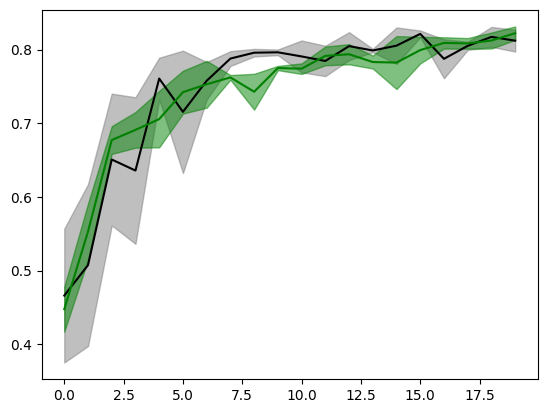

In [13]:
final_df